In [9]:
# Load model
# Faster RCNN prediction
# Extract ROI
# Mask RCNN prediction
# Extract color information
# 3D scatter plot

# Load model


In [10]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torch.nn as nn
import torch
import torchvision
from PIL import Image
import matplotlib.pyplot as plt

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torch.utils.data import DataLoader, Dataset

from torchvision import transforms as T

In [11]:
# Load mask rcnn model
def get_model(num_classes):
    pretrained_base_model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    # print(pretrained_base_model)

    in_features = pretrained_base_model.roi_heads.box_predictor.cls_score.in_features
    pretrained_base_model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    mask_in_channels = pretrained_base_model.roi_heads.mask_predictor.conv5_mask.in_channels
    pretrained_base_model.roi_heads.mask_predictor = MaskRCNNPredictor(mask_in_channels, 256, num_classes)
    return pretrained_base_model

num_classes = 2  # the background class and the pedestrian class
maskrcnn = get_model(num_classes)
device = torch.device('cpu')
maskrcnn = torch.load("maskrcnn.pth", map_location=device)
maskrcnn = maskrcnn.to(device)

In [12]:
# Load faster rcnn model
fasterrcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = fasterrcnn.roi_heads.box_predictor.cls_score.in_features
fasterrcnn.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)
fasterrcnn.load_state_dict(torch.load("fasterrcnn.pth", map_location=device))
fasterrcnn = fasterrcnn.to(device)

# Generate Faster RCNN Prediction

In [13]:
# Generate faster RCNN prediction
def predict(model, images):
    model.eval()
    images = list(image.to(device) for image in images)
    outputs = model(images)
    return outputs

# Draw bounding box on processed image (1024x1024)
def draw_boxes_on_image(boxes, images):
    for box in boxes:
        cv2.rectangle(images,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (220, 0, 0), 3)
    return images

# Extract maize tassel image from bounding box
def extract_roi(img, img_id, boxes, output_directory):
    roi_folder = os.path.join(output_directory, 'ROI')
    os.makedirs(roi_folder, exist_ok=True)
    for i, box in enumerate(boxes):
        x1 = box[0]
        y1 = box[1]
        x2 = box[2]
        y2 = box[3]
        # Extract the region of interest (ROI)
        roi = img[y1:y2, x1:x2]

        # Save the ROI
        output_path = os.path.join(roi_folder, f'{img_id}_{i+1}.jpg')
        cv2.imwrite(output_path, roi)

# Resize bounding box coordinates to original image size
def resize_bbox(original_width, original_height, boxes):
    for box in boxes:

        # Extract coordinates
        x1 = box[0]
        y1 = box[1]
        x2 = box[2]
        y2 = box[3]

        # Calculate scale factor
        width_scale = original_width / 1024
        height_scale = original_height / 1024

        # Calculate new coordinates
        resized_x1 = int(x1 * width_scale)
        resized_y1 = int(y1 * height_scale)
        resized_x2 = int(x2 * width_scale)
        resized_y2 = int(y2 * height_scale)

        # Assign new coordinates
        box[0] = resized_x1
        box[1] = resized_y1
        box[2] = resized_x2
        box[3] = resized_y2
        
    return boxes

# faster rcnn inference
def process_images_and_predict(input_directory, output_directory='output', detection_threshold=0.6):
    # Ensure output directory exists
    os.makedirs(output_directory, exist_ok=True)

    # List all image files in the input directory
    image_files = [f for f in os.listdir(input_directory) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]

    for img_name in image_files:
        
        # Read and preprocess image
        img_id = img_name.split('.')[0]
        image_path = os.path.join(input_directory, img_name)
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (1024, 1024), cv2.INTER_AREA)
        img_res /= 255.0

        # Generate Faster RCNN prediction
        output = predict(fasterrcnn, [torch.tensor(img_res, dtype=torch.float32).permute(2, 0, 1).to(device)])
        prediction_boxes = output[0]['boxes'].data.cpu().numpy()
        scores = output[0]['scores'].data.cpu().numpy()

        # Filter boxes based on detection threshold
        prediction_boxes = prediction_boxes[scores >= detection_threshold].astype(np.int32)

        # Resize bounding boxes to original image size
        prediction_boxes_resized = resize_bbox(img.shape[1], img.shape[0], prediction_boxes)

        # Draw bounding box on image and save
        img_with_boxes = draw_boxes_on_image(prediction_boxes_resized, img_rgb)
        bbox_path = os.path.join(output_directory, 'detection')
        os.makedirs(bbox_path, exist_ok=True)
        output_path = os.path.join(bbox_path, f'{img_id}_with_boxes.jpg')
        cv2.imwrite(output_path, cv2.cvtColor(img_with_boxes, cv2.COLOR_RGB2BGR))

        # Run extract ROI for image
        extract_roi(img, img_id, prediction_boxes_resized, output_directory)

# Call the function with the input directory
input_directory = 'input'
process_images_and_predict(input_directory)

# Generate Mask RCNN Prediction

In [35]:
def process_images_in_directory(input_directory, model, device):
    def get_dominant_color_hsv(region):
        # Convert the region to HSV color space
        region_hsv = cv2.cvtColor(region, cv2.COLOR_BGR2HSV)
        
        # Filter out black pixels
        non_black_pixels = (region_hsv[..., 2] != 0)
        region_without_black = region_hsv[non_black_pixels]

        # Calculate the mean color in HSV space
        dominant_color_hsv = np.mean(region_without_black, axis=0)
        
        return dominant_color_hsv

    model.eval()
    result_list = []

    for filename in os.listdir(input_directory):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(input_directory, filename)

            # Read and process image
            img = Image.open(img_path)
            height, width = img.size
            resized_img = img.resize((256, 256))
            transform = T.ToTensor()
            img_tensor = transform(resized_img)

            # Get mask rcnn prediction
            with torch.no_grad():
                pred = model([img_tensor.to(device)])

            # Get mask output
            mask = (pred[0]["masks"][0].cpu().detach().numpy() * 255).astype("uint8").squeeze()

            # Resize mask
            resized_mask = cv2.resize(mask, (height, width))

            # Convert to binary mask
            binary_mask = resized_mask > 100

            # Get mask region
            img_numpy = np.array(img)
            binary_mask = binary_mask.astype(np.uint8)
            masked_image = cv2.bitwise_and(img_numpy, img_numpy, mask=binary_mask)

            # Get dominant color info
            dominant_color = get_dominant_color_hsv(masked_image)

            # Save result
            result_list.append({
                'filename': filename,
                'dominant_color': dominant_color,
            })

    return result_list

roi_directory = "output/ROI"
result = process_images_in_directory(roi_directory, maskrcnn, device)

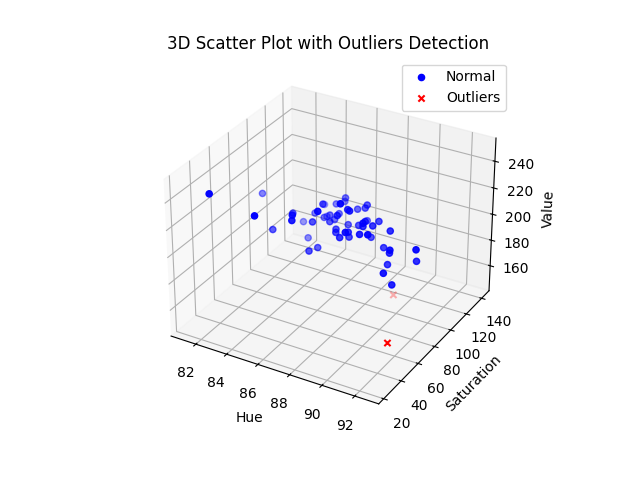

In [36]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
%matplotlib widget
dominant_colors = np.array([entry['dominant_color'] for entry in result])
def detect_outliers(data):
    q1 = np.percentile(data[:, 2], 25)
    q3 = np.percentile(data[:, 2], 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.25 * iqr
    #upper_bound = q3 + 1.5 * iqr
    outliers = ((data[:, 2] < lower_bound))
    return outliers

# Detect outliers
outliers = detect_outliers(dominant_colors)
outlier_filenames = [result[i]['filename'] for i in range(len(result)) if outliers[i]]

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot normal data points
ax.scatter(dominant_colors[~outliers, 0], dominant_colors[~outliers, 1], dominant_colors[~outliers, 2], c='b', marker='o', label='Normal')

# Plot outliers in a different color
ax.scatter(dominant_colors[outliers, 0], dominant_colors[outliers, 1], dominant_colors[outliers, 2], c='r', marker='x', label='Outliers')

ax.set_xlabel('Hue')
ax.set_ylabel('Saturation')
ax.set_zlabel('Value')
ax.set_title('3D Scatter Plot with Outliers Detection')
ax.legend()

plt.show()

In [37]:
outlier_filenames

['T0001_XM_20110810160246_01_Maize_1.jpg',
 'XAM05_YM_20150730160225_01_7_jpg.rf.57227f749af565362375b8f2e18d95a0.jpg']

In [33]:
outlier_col = [result[i]['dominant_color'] for i in range(len(result)) if outliers[i]]

In [34]:
outlier_col

[array([ 90.70152091,  82.5965357 , 168.07731305])]